In [30]:
%matplotlib widget
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import interpolate
import sys
from tqdm import tqdm

sys.path.append('/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability')
import proba_modules as pm
reload(pm)

<module 'proba_modules' from '/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/proba_modules.py'>

In [5]:
file_atmos = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/data/profile_VCD_for_scaling_pd.csv'
profile = pd.read_csv(file_atmos)
f_rho = interpolate.interp1d(profile.altitude/1e3, profile.rho, kind='quadratic')
f_t = interpolate.interp1d(profile.altitude/1e3, profile.t, kind='quadratic')
f_gamma = interpolate.interp1d(profile.altitude/1e3, profile.gamma, kind='quadratic')
f_c = interpolate.interp1d(profile.altitude/1e3, profile.c, kind='quadratic')

In [68]:
reload(pm)

dir_GF = '/projects/restricted/infrasound/data/infrasound/2023_Venus_inversion/'
freq = [0.01, 0.1, 1.]
alt_balloon = 45.
files = ['GF_Dirac_1Hz_all_wfreq_Cold100_u.csv', 'GF_Dirac_1Hz_all_wfreq_Cold100.csv',
        'GF_Dirac_1Hz_all_wfreq_Hot25_u.csv', 'GF_Dirac_1Hz_all_wfreq_Hot25.csv',
        'GF_Dirac_1Hz_all_wfreq_Hot10_u.csv', 'GF_Dirac_1Hz_all_wfreq_Hot10.csv']
dists = np.arange(0, 18000., 5.)
m0_default = 6. 

TL_all = pd.DataFrame()
for file in tqdm(files):
    file_curve = f'{dir_GF}{file}'
    
    #print(file, file_curve)
    velocity = True
    comp = file.split('.csv')[0][-2:]
    model = file.split('wfreq_')[-1].split('_')[0].split('.')[0]
    if comp == '_u':
        velocity = False
        comp = 'u'
    else:
        comp = 'v'
        
    TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, freq, dist_min=100., rho0=f_rho(0.), rhob=f_rho(0.), use_savgol_filter=True, plot=False, scalar_moment=10e6, unknown='velocity', return_dataframe=False)
    for ff, TL in TL_new.items():
        median = TL(dists, m0_default)
        qmin = TL_new_qmin[ff](dists, m0_default)
        qmax = TL_new_qmax[ff](dists, m0_default)
        amp_loc = pd.DataFrame(np.c_[dists, median, qmin, qmax, np.zeros_like(amp)+ff], columns=['distance', 'amp_median', 'amp_qmin', 'amp_qmax', 'freq'])
        amp_loc['model'] = model
        amp_loc['comp'] = comp
        TL_all = pd.concat([TL_all, amp_loc])
TL_all['m0_default'] = m0_default

100%|██████████| 6/6 [01:28<00:00, 14.78s/it]


In [82]:
TL_all.sort_values(by=['model', 'comp', 'freq', 'distance'])

,distance,amp_median,amp_qmin,amp_qmax,freq,model,comp,m0_default
0,0.0,1.254195e-04,5.650590e-05,2.471683e-04,0.01,Cold100,u,6.0
1,5.0,1.254195e-04,5.650590e-05,2.471683e-04,0.01,Cold100,u,6.0
2,10.0,1.254195e-04,5.650590e-05,2.471683e-04,0.01,Cold100,u,6.0
3,15.0,1.254195e-04,5.650590e-05,2.471683e-04,0.01,Cold100,u,6.0
4,20.0,1.254195e-04,5.650590e-05,2.471683e-04,0.01,Cold100,u,6.0
...,...,...,...,...,...,...,...,...
3595,17975.0,5.635647e-08,2.879418e-08,1.360604e-07,1.00,Hot25,v,6.0
3596,17980.0,5.635647e-08,2.879418e-08,1.360604e-07,1.00,Hot25,v,6.0
3597,17985.0,5.635647e-08,2.879418e-08,1.360604e-07,1.00,Hot25,v,6.0
3598,17990.0,5.635647e-08,2.879418e-08,1.360604e-07,1.00,Hot25,v,6.0


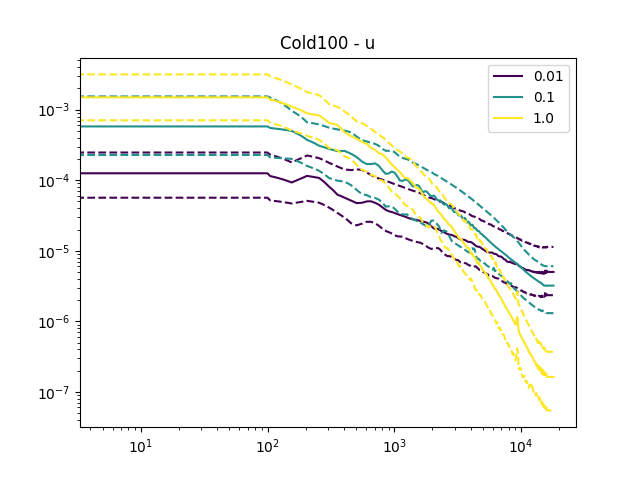

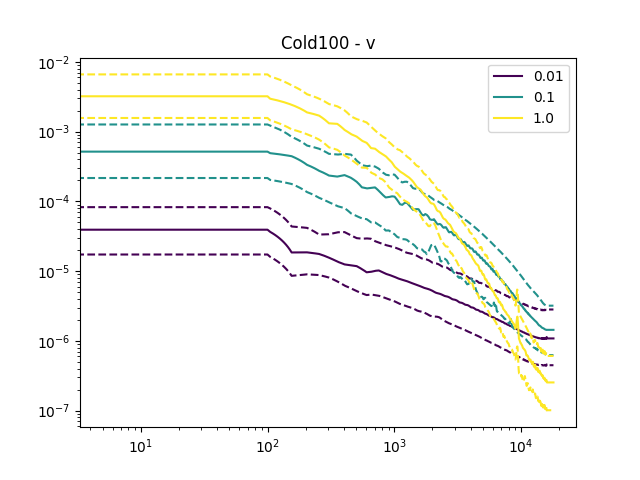

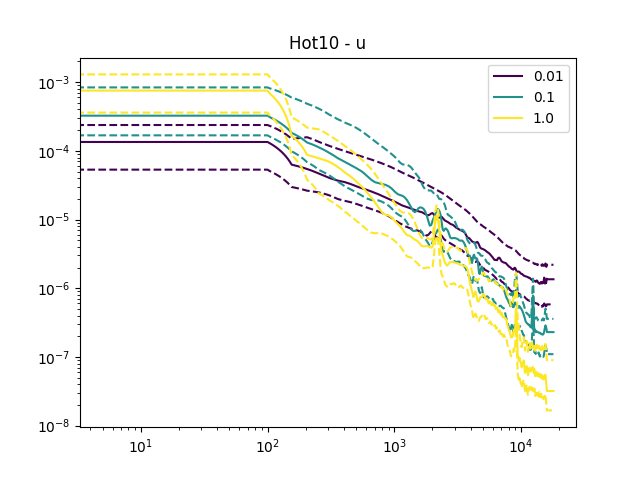

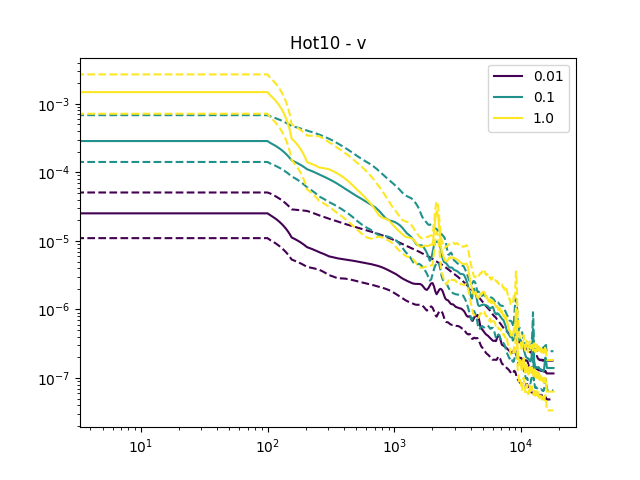

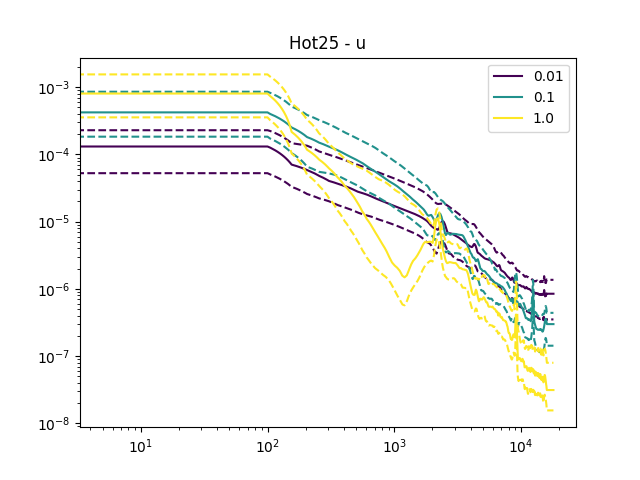

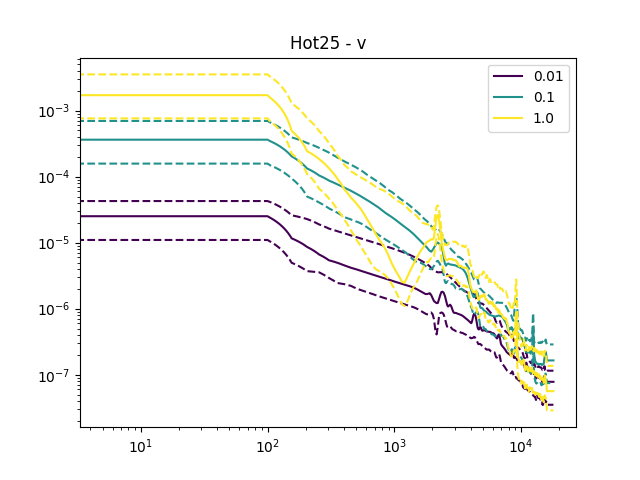

In [81]:
cmap = plt.get_cmap('viridis')  # or 'plasma', 'inferno', 'coolwarm', etc.
n = len(TL_all.freq.unique())
colors = [cmap(i / (n - 1)) for i in range(n)]

for (model, comp), TL_loc in TL_all.groupby(['model', 'comp']):
    plt.figure()
    plt.title(f'{model} - {comp}')
    ii = -1
    for ff, TL in TL_loc.groupby('freq'):
        ii += 1
        TL = TL.sort_values(by=['distance'])
        plt.plot(TL.distance, TL.amp_median, label=ff, color=colors[ii])
        plt.plot(TL.distance, TL.amp_qmin, ls='--', color=colors[ii])
        plt.plot(TL.distance, TL.amp_qmax, ls='--', color=colors[ii])
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

In [83]:
TL_all.sort_values(by=['model', 'comp', 'freq', 'distance']).to_csv(f'{dir_GF}GF_Dirac_1Hz_combined.csv', header=True, index=False)

In [140]:
reload(pm)
file_curve = f'{dir_GF}GF_Dirac_1Hz_combined.csv'
alt = 50.
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves_precomputed(file_curve, rho0=f_rho(0.), rhob=f_rho(alt), cb=f_c(alt), unknown='pressure', model='Cold100')

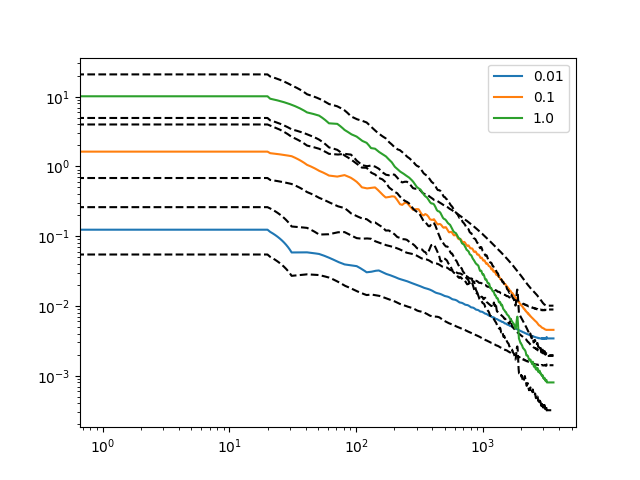

In [141]:
dists = np.arange(0, 18000., 5.)
m0 = 6. 

plt.figure()
for freq, TL in TL_new.items():
    plt.plot(TL(dists, m0), label=freq)
    plt.plot(TL_new_qmin[freq](dists, m0), color='black', ls='--')
    plt.plot(TL_new_qmax[freq](dists, m0), color='black', ls='--')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [134]:
np.exp(-np.cumsum(alpha[ifreq, :]) * dalt/1e3)

masked_array(data=[0.9999999907516293, 0.9999999813088524,
                   0.9999999716665399, 0.9999999618201822,
                   0.9999999517661727, 0.9999999415001202,
                   0.9999999310164599, 0.9999999203103961,
                   0.9999999093771976, 0.9999998982103587,
                   0.9999998868039905, 0.999999875152941,
                   0.9999998632519546, 0.9999998510942556,
                   0.9999998386717615, 0.9999998259786888,
                   0.9999998130091362, 0.9999997997570679,
                   0.9999997862163198, 0.9999997723762567,
                   0.99999975822941, 0.9999997437689683,
                   0.9999997289879652, 0.9999997138792805,
                   0.9999996984356375, 0.9999996826495952,
                   0.9999996665060955, 0.9999996499969488,
                   0.9999996331138628, 0.9999996158483513,
                   0.9999995981917325, 0.9999995801351356,
                   0.9999995616694844, 0.9999995427854914,


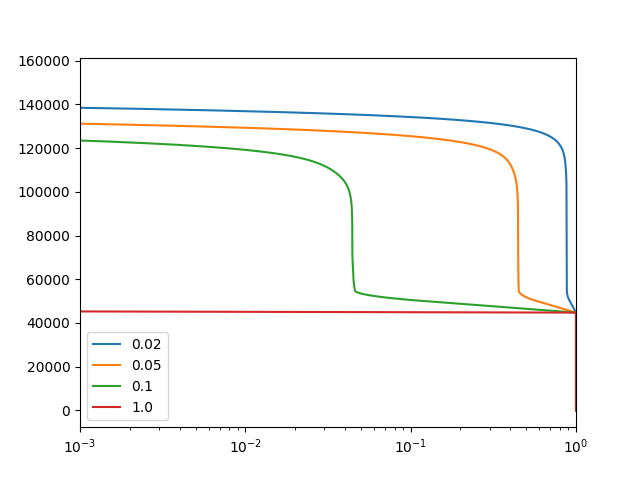

In [136]:
dalt = altitude[1] - altitude[0]
plt.figure()
for ifreq in range(alpha.shape[0]):
    atten = np.exp(-np.cumsum(alpha[ifreq, :]) * dalt/1e3)
    plt.plot(atten, altitude, label=frequency[ifreq])
plt.xscale('log')
plt.xlim([1e-3, 1])
plt.legend()